Preparing Data
==============

This notebook shows how to process the image stack locally and prepare it for loading it into the Dask cluster.

The image data is from this paper:

Du Plessis, A., Broeckhoven, C., Guelpa, A., & le Roux, S. G. (2017). Laboratory x-ray micro-computed tomography: a user guideline for biological samples. GigaScience, 6(6), 1–11. doi:10.1093/gigascience/gix027 

And specifically you can download the data from this link: ftp://parrot.genomics.cn/gigadb/pub/10.5524/100001_101000/100294/wholechameleontiff.zip

It is a stack of 16 bit TIFF images from a Micro CT scan of a taxydermied Jackson's chameleon. 

In [1]:
import numpy as np
import scipy as sp
import scipy.misc
import glob
import dask
import dask.array as da
import skimage.io
import zarr
import matplotlib.pyplot as plt
%matplotlib inline

The data is present as a stack of 16 bit TIFF images.

In [2]:
files = list(sorted(glob.glob("/home/andi/imaging/demo/chameleon/data/stack*.tif")))

Acquire dimension of the volume.

In [3]:
def read_img(f):
    return skimage.io.imread(f)
img = read_img(files[0])
size_x, size_y, size_z = img.shape[0], img.shape[1], len(files)
size_x, size_y, size_z

(1536, 1219, 1645)

Construct a stack of images as Dask arrays.

In [4]:
lazy_imread = dask.delayed(read_img, pure=True) 
lazy_images = [lazy_imread(f) for f in files]
arrays = [da.from_delayed(lazy_image,           
                          dtype=img.dtype,
                          shape=img.shape)
          for lazy_image in lazy_images]
stack = da.stack(arrays, axis=2)

The result is a volume, chunked along the Z axis.

Because Dask is quite smart, loading a slice along the Z axis will be significantly faster than along the other two.

In [6]:
%%time
img = stack[:,:,700].compute()

CPU times: user 16 ms, sys: 347 µs, total: 16.4 ms
Wall time: 53.2 ms


In [8]:
%%time
img = stack[:,700,:].compute()

CPU times: user 11.5 s, sys: 7.07 s, total: 18.6 s
Wall time: 1min 22s


In order to slice along a non-stack axis, dask has to load all of the images, and take out the one column. That is why this takes so long. It also means though, that we don't need to keep the whole volume in RAM.

The following will sum up the volume along another axis. This will take quite long, but it won't break the RAM.

In [9]:
%%time
y = stack.sum(axis=0, dtype=np.float32).compute()

CPU times: user 15.7 s, sys: 3.64 s, total: 19.3 s
Wall time: 1min 11s


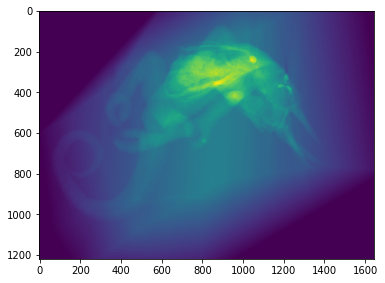

In [15]:
f,ax = plt.subplots()
f.set_figwidth(6)
f.set_figheight(6)
ax.imshow(y);

Let's determine how many chunks are in the volume.

In [16]:
[len(stack.chunks[i]) for i in range(3)]

[1, 1, 1645]

Every image has been loaded as one chunk, so we have 1645 chunks in the Z axis, one chunk each in the other two.

Let's improve that.

In [17]:
rechunked = stack.rechunk(chunks=100)
[len(rechunked.chunks[i]) for i in range(3)]

[16, 13, 17]

Much better. "rechunked" hasn't been computed yet. We can store it into the zarr format like this:

In [18]:
rechunked.to_zarr("chameleon.zarr", overwrite=True)

This action is performed immediately, without the need for ".compute()". Dasks storage functions take care of memory, so even if the data is quite large, it is loaded and saved in manageable chunks.

Just for illustration purposes, this will give informatin about the zarr file:

In [20]:
chameleon_zarr = zarr.open("chameleon.zarr", mode="r")
chameleon_zarr.info

Type,zarr.core.Array
Data type,uint16
Shape,"(1536, 1219, 1645)"
Chunk shape,"(100, 100, 100)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,6160143360 (5.7G)
No. bytes stored,1792160888 (1.7G)
Storage ratio,3.4


So we have a compression rate of 3.5, from 5.7G to 1.6G. The original volume will fit into the RAM of most consumer PCs. The problems start when we handle more than one such volume or even convert it to a 32bit float.

In [21]:
vol = da.from_zarr("chameleon.zarr")

In [23]:
%%time
y = vol[:,700,:].compute()

CPU times: user 645 ms, sys: 131 ms, total: 776 ms
Wall time: 1.29 s


In [24]:
%%time
y = vol.mean(axis=1, dtype=np.float32).compute()

CPU times: user 23.6 s, sys: 2.01 s, total: 25.6 s
Wall time: 1min 15s


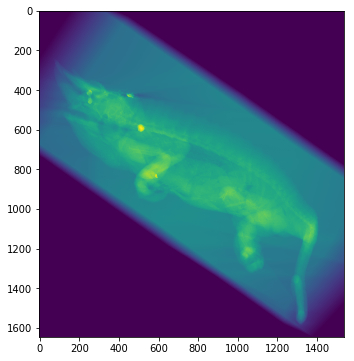

In [26]:
f,ax = plt.subplots()
f.set_figwidth(6)
f.set_figheight(6)
ax.imshow(y.transpose()[::-1]);

A very nice operation for X-Ray absorption data is the "max" operation:

In [29]:
%%time
y = vol.max(axis=1).compute()

CPU times: user 44.2 s, sys: 5.17 s, total: 49.3 s
Wall time: 47.4 s


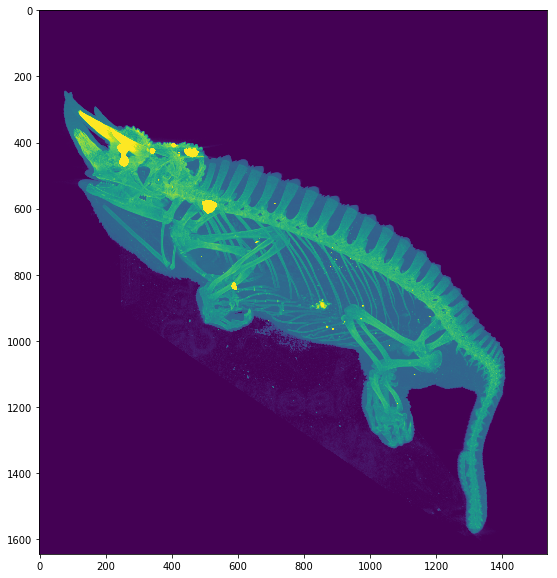

In [28]:
f,ax = plt.subplots()
f.set_figwidth(10)
f.set_figheight(10)
ax.imshow(y.clip(3000,20000).transpose()[::-1]);

The next notebook in this series will show how to distribute volume-related workloads on a Dask cluster.